# Kratos example: linear model

In [1]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombineType, CombinerMethod, CompareType
from probabilistic_library import UncertaintyProject, UncertaintyMethod, Stochast

### Model

In [2]:
from run_kratos_quay_wall import zfuncwrapper_linear

### Variables

In [ ]:
def define_project_variables(project):

    project.variables["geo_young_modulus"].is_array = True
    project.variables["geo_young_modulus"].array_size = 7
    for i in range(project.variables["geo_young_modulus"].array_size):
        if i in [0, 1, 2, 3, 4]: # Clays with low-medium plasticity, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 5*10**6
            young_modulus.maximum = 8*10**6
        elif i in [5, 6]: # Sand, uniform, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 30*10**6
            young_modulus.maximum = 50*10**6
        project.variables["geo_young_modulus"].array_variables.append(young_modulus)

    project.variables["sheetpile_young_modulus"].distribution = DistributionType.deterministic
    project.variables["sheetpile_young_modulus"].is_array = True
    project.variables["sheetpile_young_modulus"].array_size = 1
    project.variables["sheetpile_young_modulus"].mean = 200e9 # value checked

    project.variables["sheetpile_poisson_ratio"].distribution = DistributionType.deterministic
    project.variables["sheetpile_poisson_ratio"].is_array = True
    project.variables["sheetpile_poisson_ratio"].array_size = 1
    project.variables["sheetpile_poisson_ratio"].mean = 0.0 # value checked

    project.variables["sheetpile_thickness"].distribution = DistributionType.deterministic
    project.variables["sheetpile_thickness"].is_array = True
    project.variables["sheetpile_thickness"].array_size = 1
    project.variables["sheetpile_thickness"].mean = 0.02159 # value checked

    return project

### Uncertainty analysis (max y-displacement)

In [ ]:
project = UncertaintyProject()
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_y_displacement

project.model.print()

Model max_y_displacement:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  np.abs(max_y_displacement)


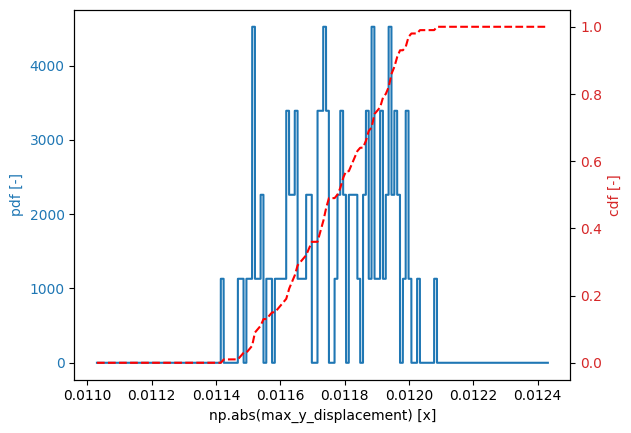

In [6]:
project = define_project_variables(project)

project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.stochast.plot()

### Uncertainty analysis (max bending moment)

In [7]:
project = UncertaintyProject()

# gives interesting results when stage is 3
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.max_bending_moment

project.model.print()

Model max_bending_moment:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  max_bending_moment


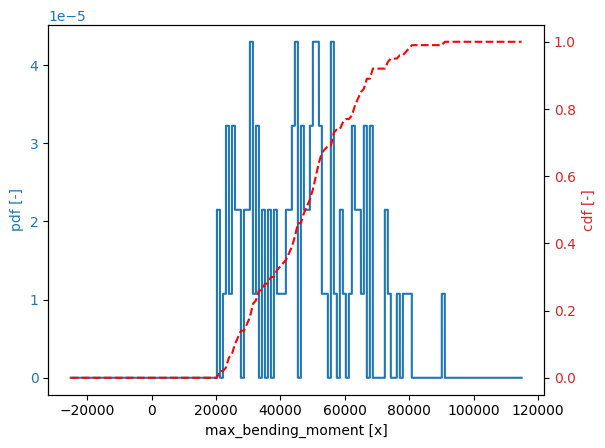

In [8]:
project = define_project_variables(project)

project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.stochast.plot()

### Reliability analysis (max y-displacement)

In [31]:
project = ReliabilityProject()

# gives interesting results when stage is 0
wrapper = zfuncwrapper_linear(output_stage_number = 0, clean_up = True)
project.model = wrapper.max_y_displacement

project.model.print()

Model max_y_displacement:
Input parameters:
  geo_young_modulus[1]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  np.abs(max_y_displacement)


In [32]:
project = define_project_variables(project)

project.settings.reliability_method = ReliabilityMethod.form
project.settings.variation_coefficient = 0.02
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 0.3

project.run()

project.design_point.print()

dp1 = project.design_point

Reliability (FORM)
 Reliability index = 1.085
 Probability of failure = 0.139
 Convergence = 0.004781 (converged)
 Model runs = 56
Alpha values:
 geo_young_modulus[0]: alpha = -0.001048, x = 6.501e+07
 geo_young_modulus[1]: alpha = 0.08114, x = 6.395e+07
 geo_young_modulus[2]: alpha = -0.007398, x = 6.51e+07
 geo_young_modulus[3]: alpha = 0.261, x = 6.166e+07
 geo_young_modulus[4]: alpha = -0.03418, x = 6.544e+07
 geo_young_modulus[5]: alpha = 0.7018, x = 5.67e+07
 geo_young_modulus[6]: alpha = 0.6569, x = 5.714e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159



### Reliability analysis (max bending moment)

In [33]:
# gives interesting results when stage is 3
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.max_bending_moment

project.model.print()

# form does not work!
project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 4000

project.run()

project.design_point.print()

dp2 = project.design_point

Model max_bending_moment:
Input parameters:
  geo_young_modulus[7]
  sheetpile_young_modulus[1]
  sheetpile_poisson_ratio[1]
  sheetpile_thickness[1]
Output parameters:
  max_bending_moment
Reliability:
 Reliability index = 0.7722
 Probability of failure = 0.22
 Convergence = 0.1883 (not converged)
 Model runs = 100
Alpha values:
 geo_young_modulus[0]: alpha = -0.01873, x = 6.517e+07
 geo_young_modulus[1]: alpha = 0.3283, x = 6.2e+07
 geo_young_modulus[2]: alpha = 0.4293, x = 6.11e+07
 geo_young_modulus[3]: alpha = -0.2406, x = 6.721e+07
 geo_young_modulus[4]: alpha = -0.4917, x = 6.944e+07
 geo_young_modulus[5]: alpha = 0.481, x = 6.065e+07
 geo_young_modulus[6]: alpha = 0.4201, x = 6.118e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159



### Combine probabilities

In [34]:
combine_project = CombineProject()

combine_project.design_points.append(dp1)
combine_project.design_points.append(dp2)

combine_project.settings.combine_type = CombineType.series
combine_project.settings.combiner_method = CombinerMethod.hohenbichler_form

combine_project.run()

combine_project.design_point.print()

Reliability:
 Reliability index = 0.5747
 Probability of failure = 0.2828
 Model runs = 0
Alpha values:
 geo_young_modulus[0]: alpha = -0.01425, x = 6.51e+07
 geo_young_modulus[0]: alpha = 0.2713, x = 6.314e+07
 geo_young_modulus[0]: alpha = 0.315, x = 6.285e+07
 geo_young_modulus[0]: alpha = -0.06088, x = 6.542e+07
 geo_young_modulus[0]: alpha = -0.376, x = 6.757e+07
 geo_young_modulus[0]: alpha = 0.6119, x = 6.088e+07
 geo_young_modulus[0]: alpha = 0.5545, x = 6.125e+07
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159

